# A look of Dataset

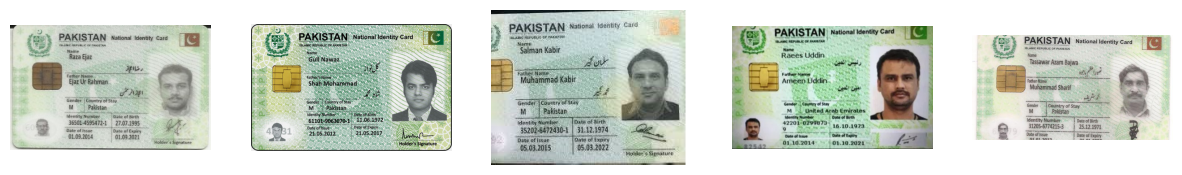

In [1]:
import random
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the path to the images folder
folder_path = 'data/images/train'

# Get a list of all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
# Randomly select 15 image files

selected_files = random.sample(image_files, 5)

# Create a figure to plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 9))  # 3 rows, 5 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each image
for ax, img_file in zip(axes, selected_files):
    img_path = os.path.join(folder_path, img_file)
    with Image.open(img_path) as img:
        ax.imshow(img)
        ax.axis('off')  # Hide axes

plt.show()

# Model Training
Model is trained over `Google Colab` using its T4 GPU. Anyhow, the code for training is in the following.

In [ ]:
root_path = '/content/gdrive/MyDrive/CNIC Dataset'
import os
from ultralytics import YOLO

# model = YOLO("yolov8n.yaml")
model = YOLO("/content/gdrive/MyDrive/CNIC Dataset/runs/detect/train/weights/best.pt")

results = model.train(data=os.path.join(root_path, "data.yaml"), epochs=50, imgsz = 480)

##### YAML File

This is the `data.yaml` file
```YAML
names:
  0: text
path: /content/gdrive/MyDrive/CNIC Dataset
train: train/images
val: val/images
```

> Model is trained through 100-100 and then 50 epochs using `yolov8n.pt` model followed by training of `best.pt`.

In the following are the final results of training the model

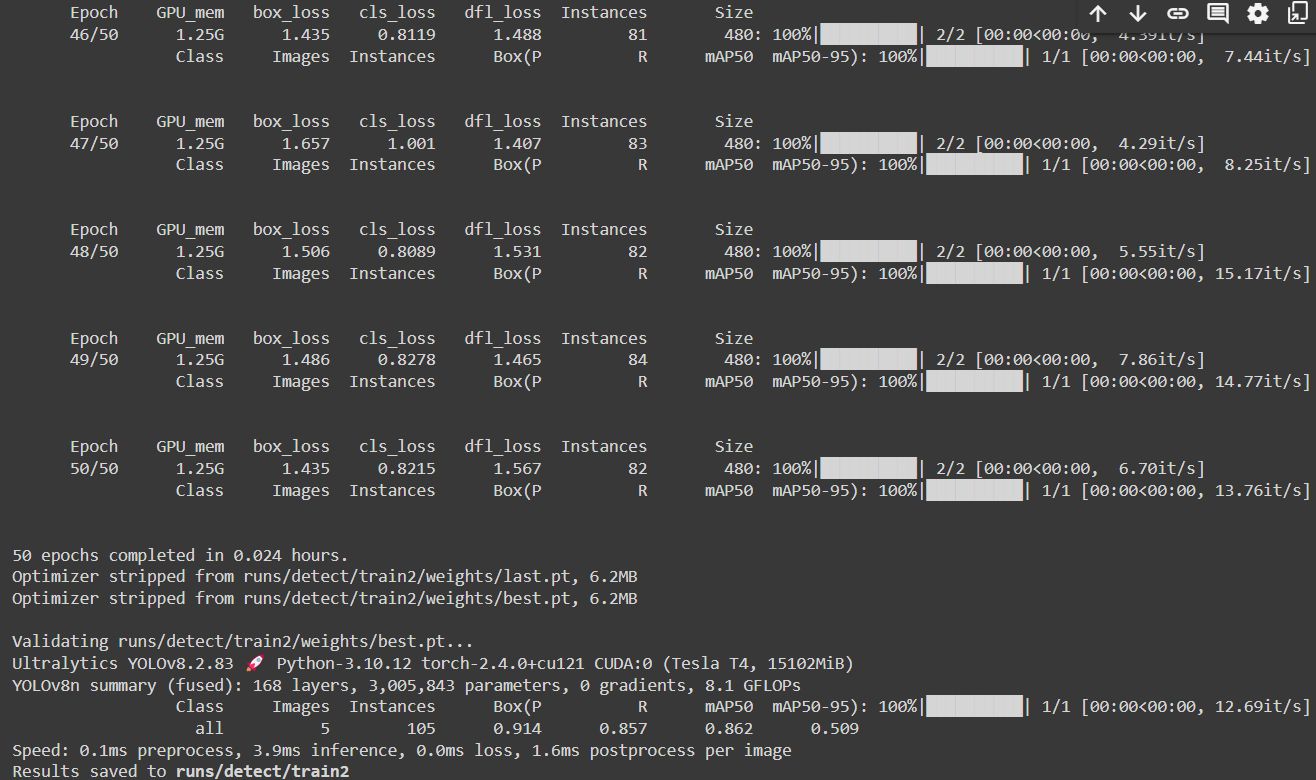

# Model Testing

Here are the results from the training of Yolov8n

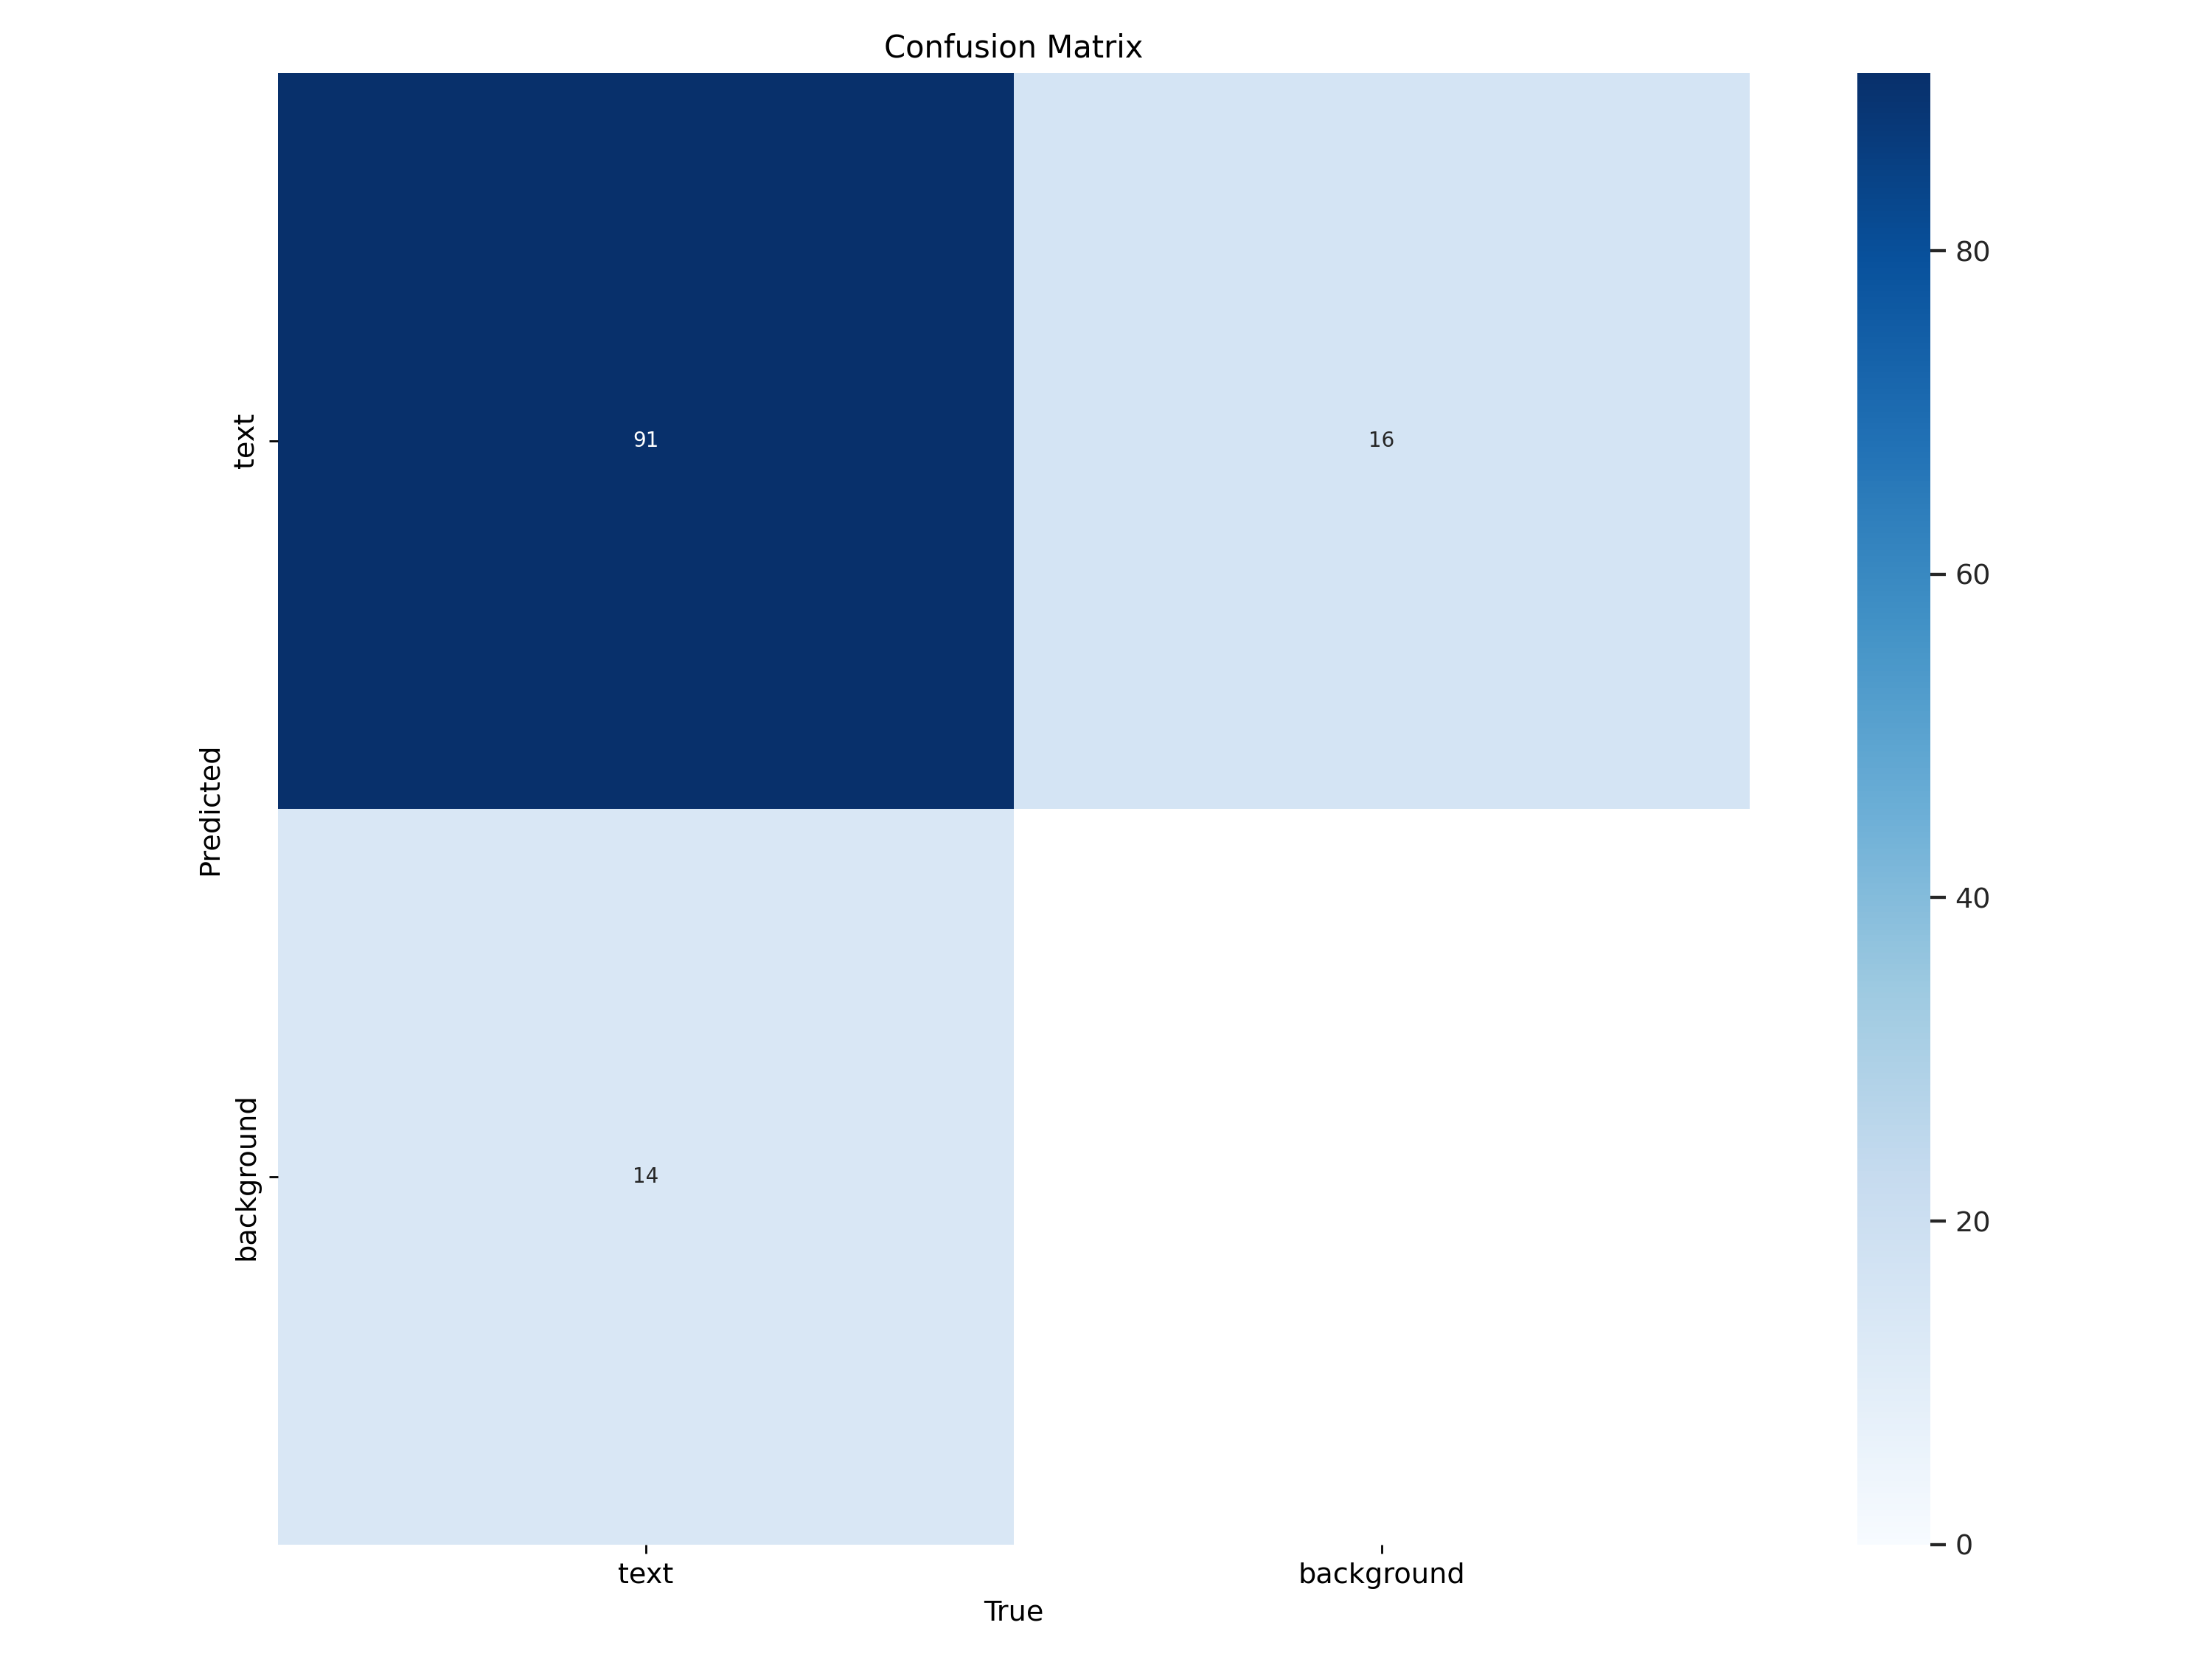

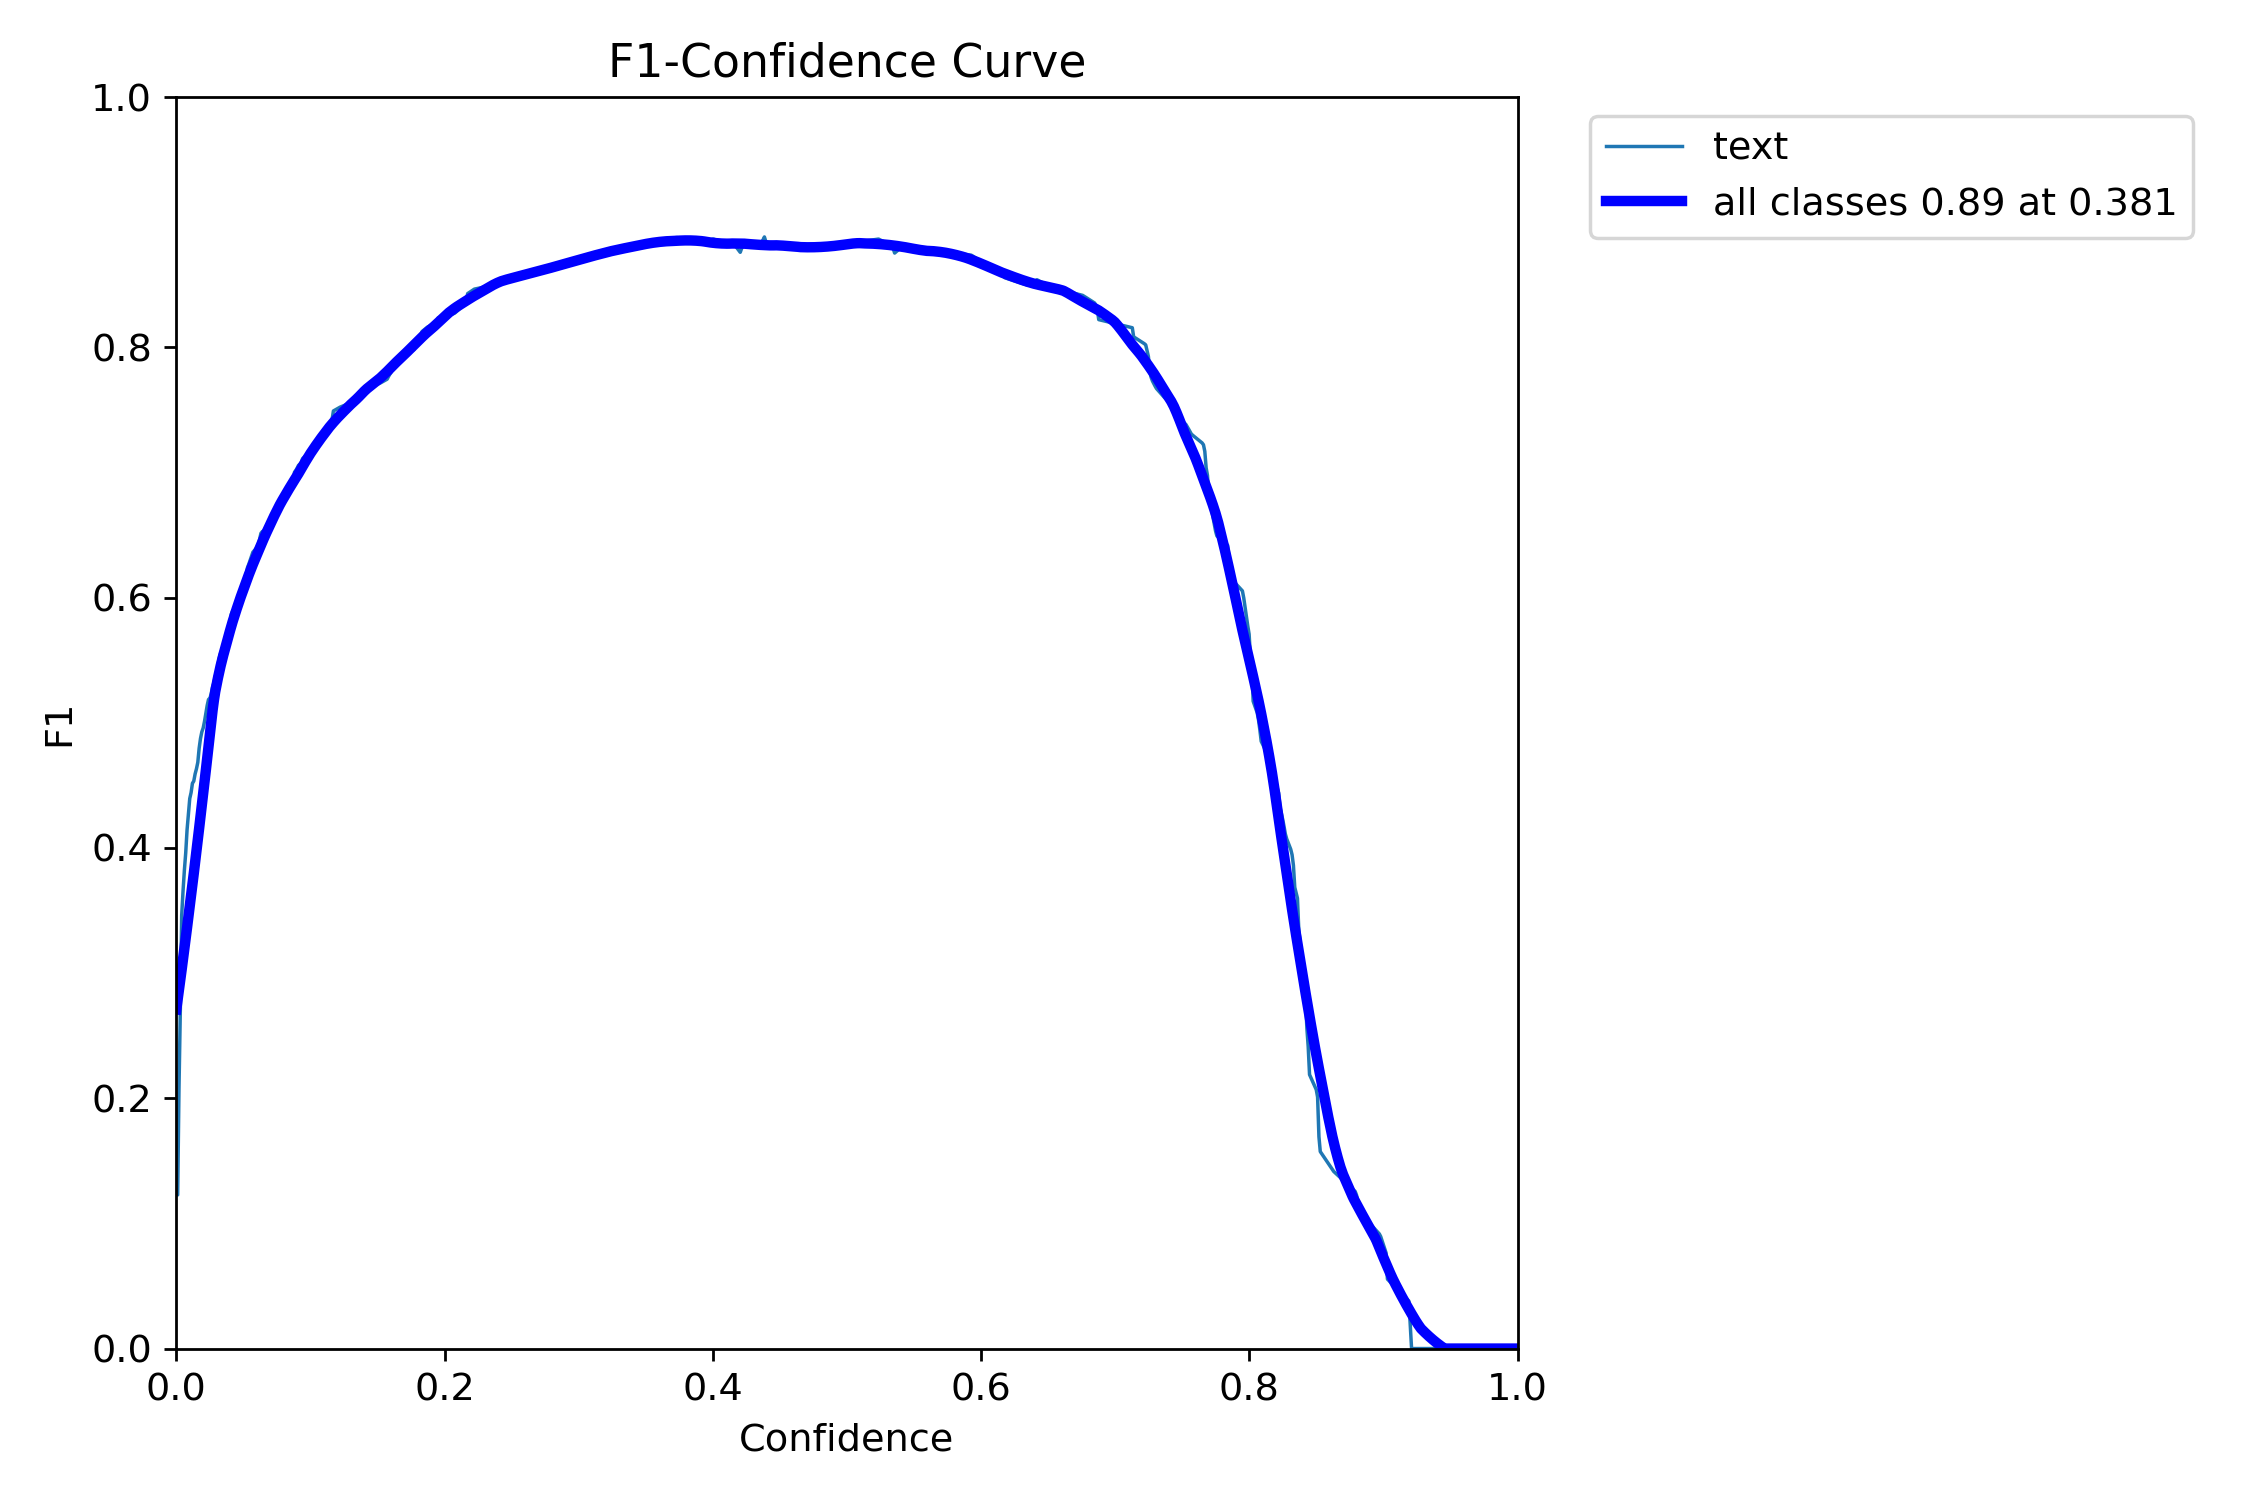

And now are the results from training and Validation Batches
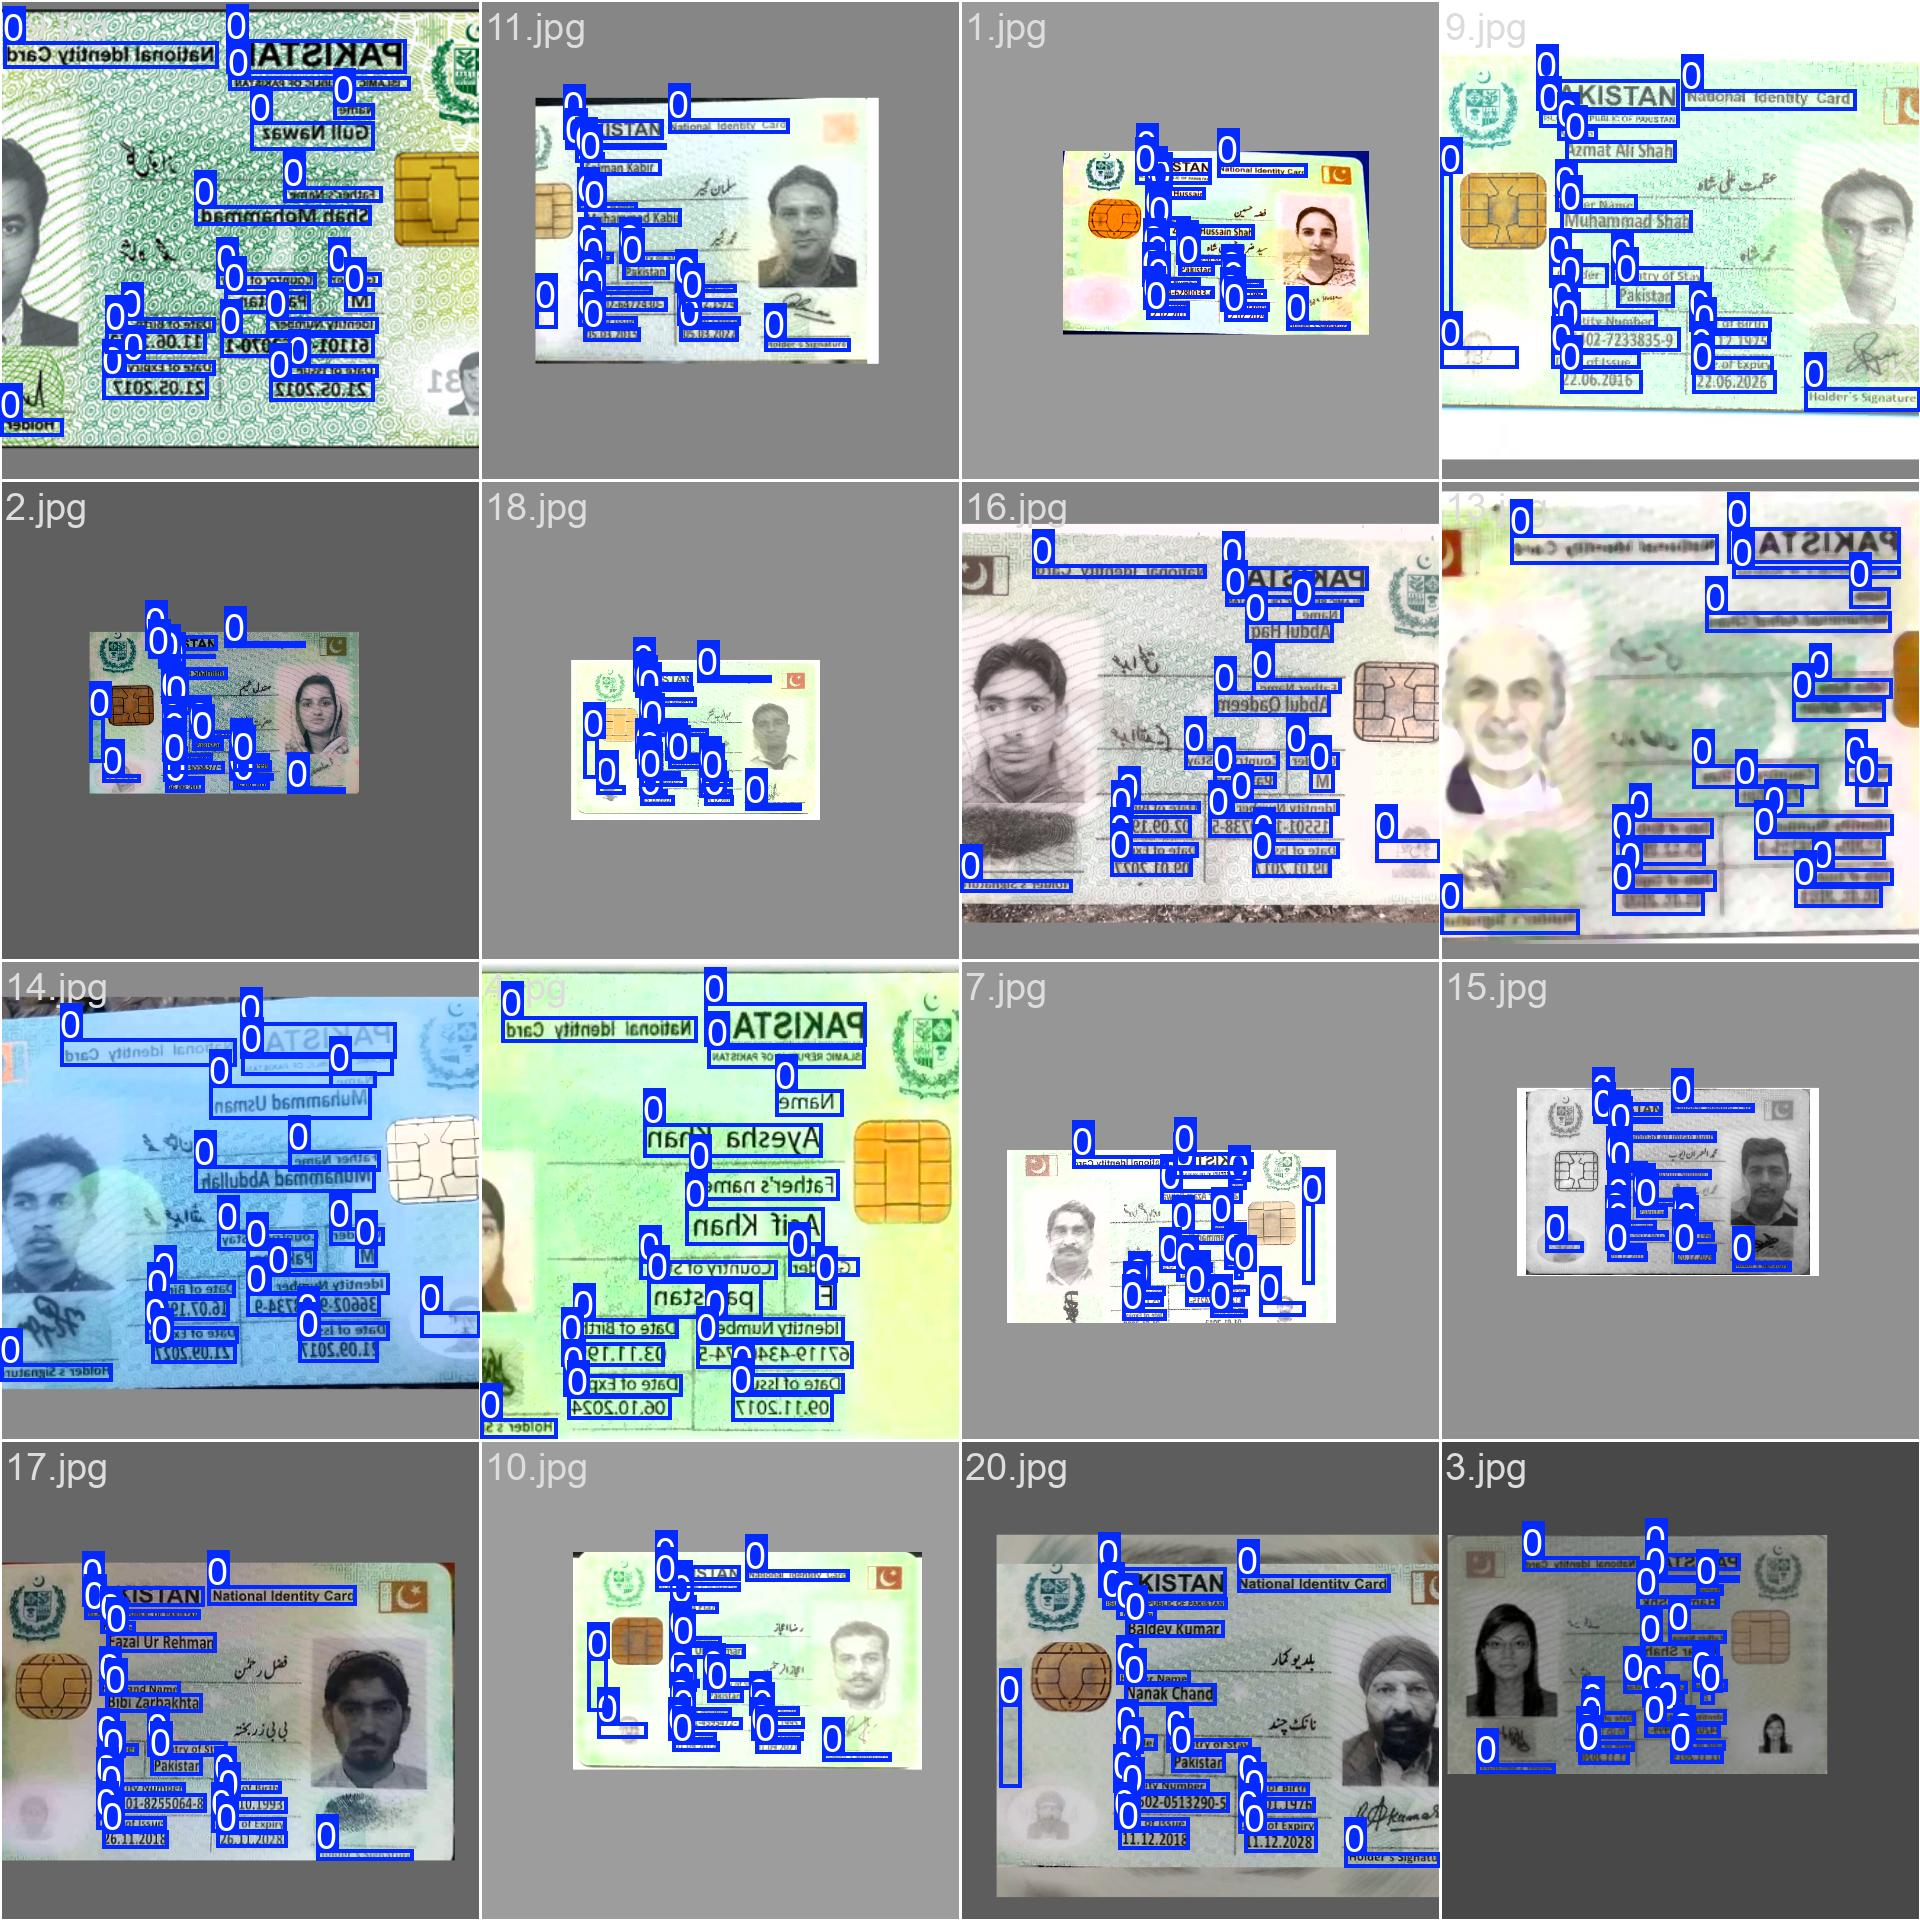
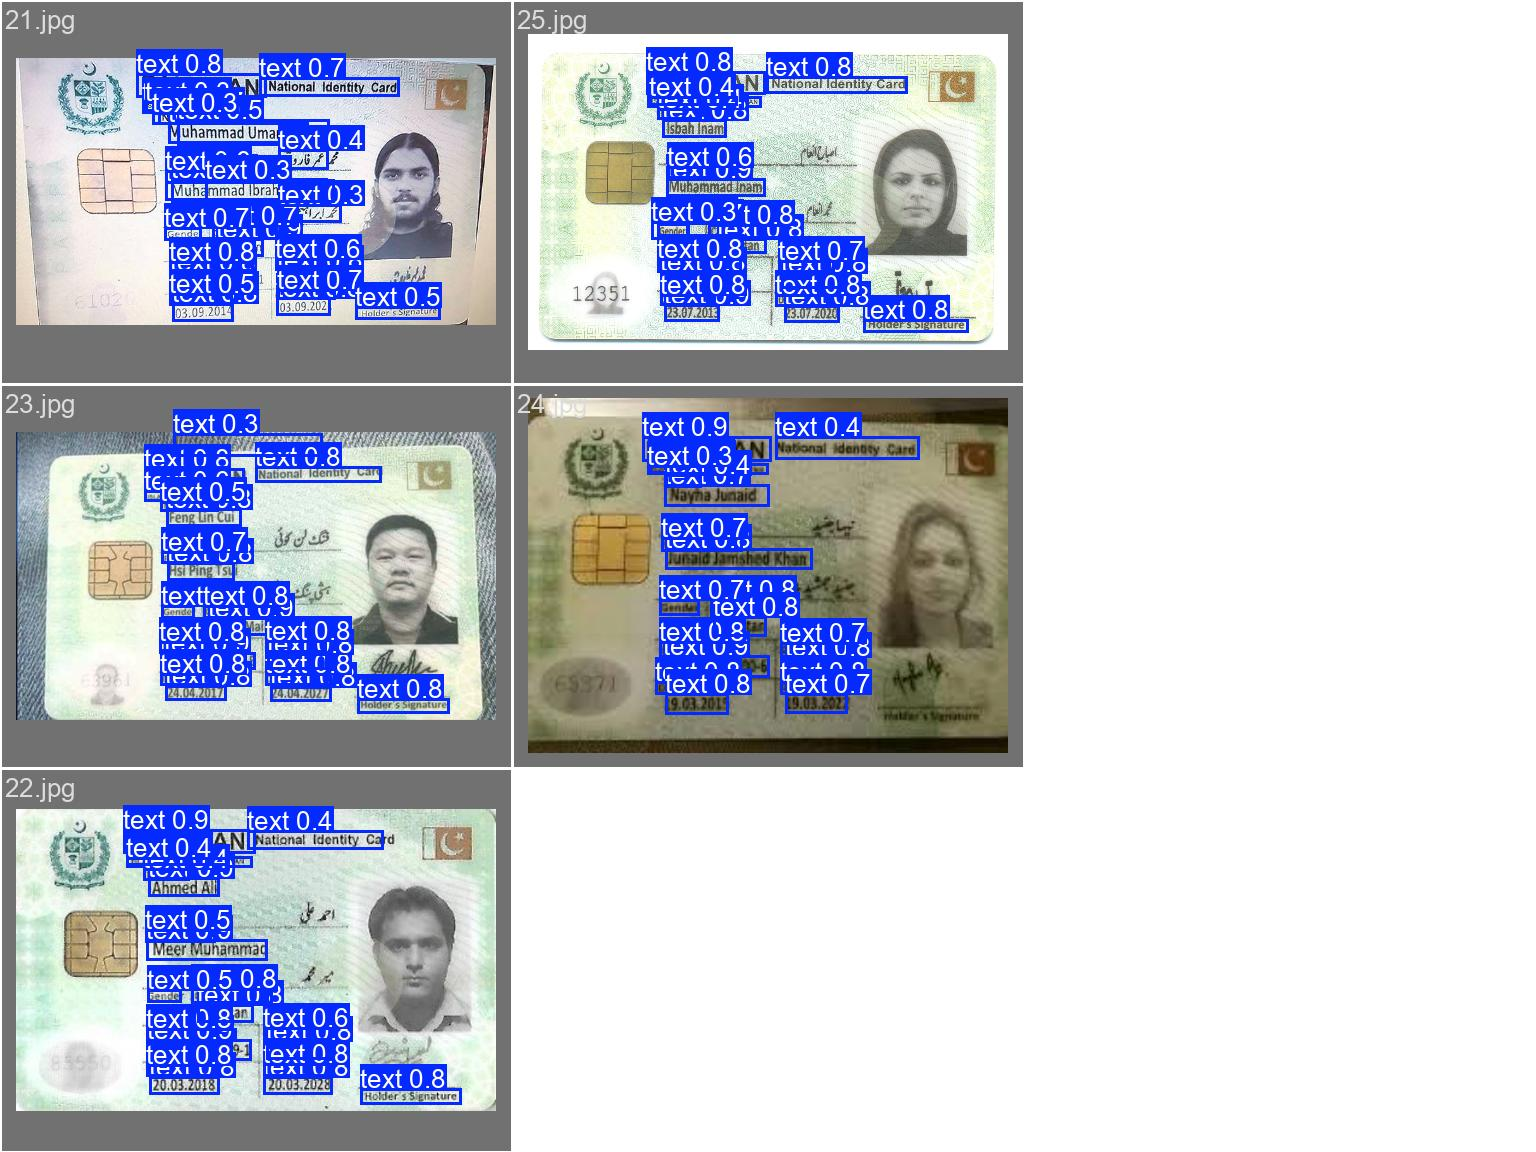

### Cropping Images


0: 288x480 21 texts, 343.4ms
Speed: 84.0ms preprocess, 343.4ms inference, 53.1ms postprocess per image at shape (1, 3, 288, 480)


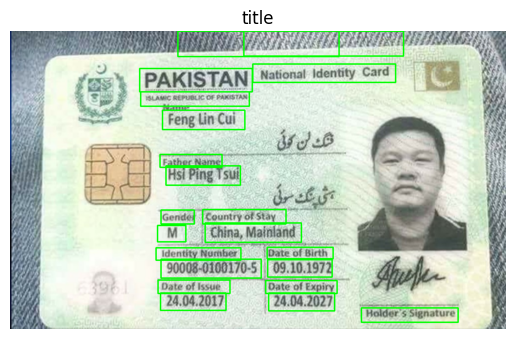

In [12]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

def process_images(image_path, model, threshold=0.15):
    image = cv2.imread(image_path)
    results = model(image)[0]
    cropped_images = []
    for x1, y1, x2, y2, score, _ in results.boxes.data.tolist():
        if score > threshold:
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cropped_image = image[int(y1):int(y2), int(x1):int(x2)]
            cropped_images.append(cropped_image)
    return image, cropped_images

# Example usage
model = YOLO(os.path.join('.', 'last.pt'))
image_path = r'test.jpg'
detected_image, cropped_images = process_images(image_path, model)

# Convert BGR image to RGB for displaying with matplotlib
detected_image_rgb = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)

# Display the image with detections in the title
plt.imshow(detected_image_rgb)
plt.axis('off')

plt.title("title")
plt.show()


## Applying OCR

In [13]:
from paddleocr import PaddleOCR
from IPython.display import clear_output

def apply_ocr_to_images(cropped_images, ocr_model):
    extracted_texts = []
    for cropped_image in cropped_images:
        result = ocr_model.ocr(cropped_image, cls=False)
        if result[0] is not None:
            text = " ".join([line[1][0] for line in result[0]])
            extracted_texts.append(text)
    return extracted_texts

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Apply OCR to cropped images
extracted_texts = apply_ocr_to_images(cropped_images, ocr)

clear_output()

for i in extracted_texts:
    print(i)


Gende
90008-0100170-5
National Identity Card
China,Mainland
Hsi Ping Tsui
09.10.1972
PAKISTAN
24.04.2027
Identity Number
Date of Expiry
24.04.2017
Holder's'Signature
Date of Birth
Feng Lin Cui
Date of Issue
FatherName
Country otStay
ISLAMIC REPUBLC OF PAKISTAN
M


# Evaluating `EAST` (pre-trained)

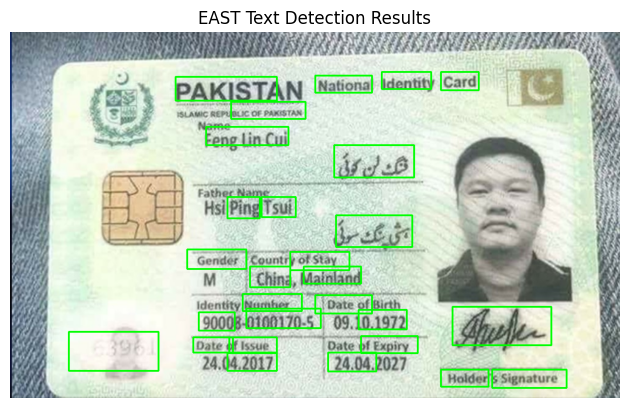

In [23]:
import os, sys
import numpy as np
import cv2
import time
from imutils.object_detection import non_max_suppression

def east_detect(image):
    layerNames = [
    	"feature_fusion/Conv_7/Sigmoid",
    	"feature_fusion/concat_3"]
    
    orig = image.copy()
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    (H, W) = image.shape[:2]
    
    # set the new width and height and then determine the ratio in change
    # for both the width and height: Should be multiple of 32
    (newW, newH) = (320, 320)
    
    rW = W / float(newW)
    rH = H / float(newH)
    
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    
    (H, W) = image.shape[:2]
    
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    	(123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    start = time.time()
    
    net.setInput(blob)
    
    (scores, geometry) = net.forward(layerNames)
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
    		# if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.5:
                continue
    		# compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
                        
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    
    # print(time.time() - start)
    return orig

image = cv2.imread("test.jpg")

out_image = east_detect(image)

plt.imshow(cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))
plt.title("EAST Text Detection Results")
plt.axis('off')
plt.tight_layout()
plt.show()